# Assignment 2 - Image Captioning

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of image captioning : -from loading and inspecting the dataset; -to implementing, training and evaluating an Encoder-Decoder + Attention based architecture. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- From the provided Flickr8k dataset, split it into train, val and test sets;
- Use the train set to train an Image Captioning model, the val set for validation of the model and hyper-parameters, and the test set to evaluate the final trained model;
- For this assignment, we will give importance to the performance of your model, meaning that, we will evaluate if your model is overfitted or underfitted. For that, please include visualizations (print and plot) loss values for the split sets, as well as the metric results;
- For the metric, while we do not require high performance, we still expect better than random guessing results;
- For the comparison, you are free to choose any pre-trained model;
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is May 15th Wednesday 11:59 PM** (strict, no late submission);
- Feel free to add more code cells as needed. But don't put code into external Python files;
- Please add your name, Neptun ID, and task details below.

**Name: Li Kailang**  
**Neptun ID: FDQAOR **

## Task description

Your task is to train your own custom image captioning model and compare its performance with an existing (pre-trained) model. For that, first you need to load the provided Flickr8k dataset, split into train, val and test sets. Then, create your own architecture, which should follow an Encoder-Decoder + Attention sturcture. You can use pre-trained backbones (i.e. ResNet) for the encoder, but they have to be fine-tuned. We expect you to use an Attention layer, in order to visualize how the network learned (see more details on section 2 of the notebook).
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs. Please use BLEU score as the metric**. We expect you to show visualizations (prints and plots) of the metrics, losses, and predictions. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your architecture.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [1]:
# ADD YOUR CODE HERE
import torch

# 1. DATASET
For this assignment you will be using the [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) dataset, which contains captions/descriptions of different images.

### 1.1. Download dataset
The best way to download this dataset is through Kaggle.
First create a token, download it and upload it here. Follow these steps: https://www.kaggle.com/discussions/general/74235

In [2]:
!pip install -q kaggle

**upload'data_2/kaggle.json'**

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chelanli","key":"125b67d5a7857bfe8f6b42dc96fb2253"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99% 1.03G/1.04G [00:05<00:00, 184MB/s]
100% 1.04G/1.04G [00:05<00:00, 202MB/s]


In [6]:
!unzip flickr8k.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed7be3.jpg  
  inflating: 

### 1.2. Load dataset
In order to load the dataset, you need to create a pytorch Dataset class.
The class should return images and captions. Remember that the captions should be returned as tokens. Do not forget to include the SOS:start of sentence, EOS:end of sentence and UNK:unknown tokens. You may want to build a vocabulary class in order to save all the words in your dataset, because your model can only predict words in your vocabulary. You do not have to save every word in your vocabulary, it is common practice to save only those words that appear multiple times in your whole dataset. For example, save only words that appear at least 5 times in your whole dataset.

In [7]:
import json


def txt_to_json(txt_file, json_file):
    data = {}
    with open(txt_file, 'r') as f:
        next(f)  # 跳过第一行
        for line in f:
            parts = line.strip().split(',')
            if len(parts) == 2:
                image, caption = parts
                image = image.strip()
                caption = caption.strip()
                if image not in data:
                    data[image] = [caption]
            else:
                print("Skipping invalid line:", line)
    with open(json_file, 'w') as jsonf:
        json.dump(data, jsonf, indent=4)

# Input and output file paths
txt_file = '/content/captions.txt'
json_file = '/content/captions.json'

# Convert the TXT file to JSON format
txt_to_json(txt_file, json_file)



Skipping invalid line: 1012212859_01547e3f17.jpg,"A dog shakes its head near the shore , a red ball next to it ."

Skipping invalid line: 1012212859_01547e3f17.jpg,"Dog with orange ball at feet , stands on shore shaking off water"

Skipping invalid line: 1022454332_6af2c1449a.jpg,"Two people are at the edge of a lake , facing the water and the city skyline ."

Skipping invalid line: 1022454428_b6b660a67b.jpg,"A couple and an infant , being held by the male , sitting next to a pond with a near by stroller ."

Skipping invalid line: 103106960_e8a41d64f8.jpg,"Hockey goalie boy in red jacket crouches by goal , with stick ."

Skipping invalid line: 103205630_682ca7285b.jpg,"Two men , standing on an ice , looking into something covered with a blue tarp ."

Skipping invalid line: 1042590306_95dea0916c.jpg,"Asian man and blond woman holding hands outdoors , man in background watches ."

Skipping invalid line: 105342180_4d4a40b47f.jpg,"A girl paddling down a large river , as seen from behind he

In [8]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import json
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
import json

class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, max_caption_length=50):
        self.root_dir = root_dir
        self.transform = transform
        self.max_caption_length = max_caption_length

        # Load captions
        with open(captions_file, 'r') as f:
            self.captions = json.load(f)

        # Extract unique image names
        self.image_names = list(self.captions.keys())

        # Build vocabulary
        self.vocab = Vocabulary()
        self.build_vocab()

    def build_vocab(self):
        word_freq = {}
        for captions in self.captions.values():
            for caption in captions:
                for word in caption.split():
                    word_freq[word] = word_freq.get(word, 0) + 1

        for word, freq in word_freq.items():
            if freq >= 5:  # Only keep words with frequency at least 5
                self.vocab.add_word(word)

    def tokenize(self, caption):
        tokens = []
        for word in caption.split():
            tokens.append(self.vocab.word2idx.get(word, self.vocab.word2idx['<UNK>']))
        return tokens

    def add_special_tokens(self, tokens):
        tokens.insert(0, self.vocab.word2idx['<SOS>'])
        tokens.append(self.vocab.word2idx['<EOS>'])
        return tokens

    def pad_or_truncate(self, tokens):
        if len(tokens) < self.max_caption_length:
            # Padding
            tokens += [self.vocab.word2idx['<PAD>']] * (self.max_caption_length - len(tokens))
            actual_length = len(tokens) - tokens.count(self.vocab.word2idx['<PAD>'])
        elif len(tokens) > self.max_caption_length:
            # Truncating
            tokens = tokens[:self.max_caption_length]
            actual_length = self.max_caption_length
        else:
            actual_length = self.max_caption_length
        return tokens, actual_length

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = f"{self.root_dir}/{img_name}"
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        captions = self.captions[img_name]
        tokenized_captions = [self.tokenize(caption) for caption in captions]
        tokenized_captions = [self.add_special_tokens(tokens) for tokens in tokenized_captions]
        tokenized_captions, lengths = zip(*[self.pad_or_truncate(tokens) for tokens in tokenized_captions])

        # Convert to tensors
        tokenized_captions = torch.LongTensor(tokenized_captions)
        lengths = torch.LongTensor(lengths)

        return image, tokenized_captions, lengths


class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

        self.add_word('<PAD>')  # Used for padding sentences to different lengths
        self.add_word('<SOS>')  # Start of sentence token
        self.add_word('<EOS>')  # End of sentence token
        self.add_word('<UNK>')  # Unknown word token

        self.freq_threshold = freq_threshold

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __len__(self):
        return len(self.word2idx)

    def numericalize(self, captions_list):
        tokenized_captions = []
        for captions in captions_list:
            captions = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in captions.split()]
            captions = [self.word2idx['<SOS>']] + captions + [self.word2idx['<EOS>']]
            tokenized_captions.append(captions)
        tokenized_captions = torch.LongTensor(tokenized_captions)
        return tokenized_captions

# Assuming you have already defined and instantiated your FlickrDataset
dataset = FlickrDataset(root_dir='/content/Images', captions_file='/content/captions.json', transform=transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()]))

Example output from dataset class

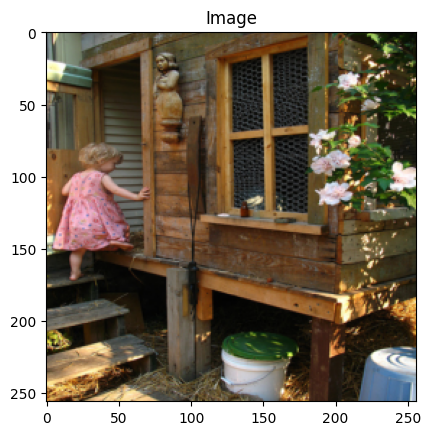

Captions:
Token: tensor([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12,  7, 13, 14, 15,  6, 16,  3, 17,
        18,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
Sentence:
['<SOS>', 'A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']



In [9]:
# Show some visualizations of the created dataset
import matplotlib.pyplot as plt
import os

def show_image(image, title=''):
    plt.imshow(image.permute(1, 2, 0))
    plt.title(title)
    plt.axis('on')
    plt.show()

# Assuming `dataset` is your FlickrDataset instance
img, caps_list, length = dataset[0]
show_image(img, "Image")
print("Captions:")
for caps in caps_list:
    print("Token:", caps)
    print("Sentence:")
    sentence = []
    for token in caps:
        try:
            word = dataset.vocab.idx2word[token.item()]
        except KeyError:
            word = "<UNK>"
        sentence.append(word)
    print(sentence)
    print()

Split your dataset into train, val and test sets

In [10]:
# ADD YOUR CODE HERE
import torch
from torch.utils.data import random_split

# 假设你已经实例化了你的 FlickrDataset
dataset = FlickrDataset(root_dir='/content/Images', captions_file='/content/captions.json', transform=transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()]))

# 定义训练集、验证集和测试集的大小（例如，70%，15%，15%）
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# 分割数据集
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# 打印每个数据集的大小
print(f"Train size: {len(train_set)}")
print(f"val size: {len(val_set)}")
print(f"test size: {len(test_set)}")


Train size: 5663
val size: 1618
test size: 810


Create a dataloader, in order to load the examples in batches. Remember that, a batch has different examples, and each example (caption) may have different sizes. Therefore, consider padding techniques for the captions. For the image, use transforms in the previous step, to ensure same format and size.  

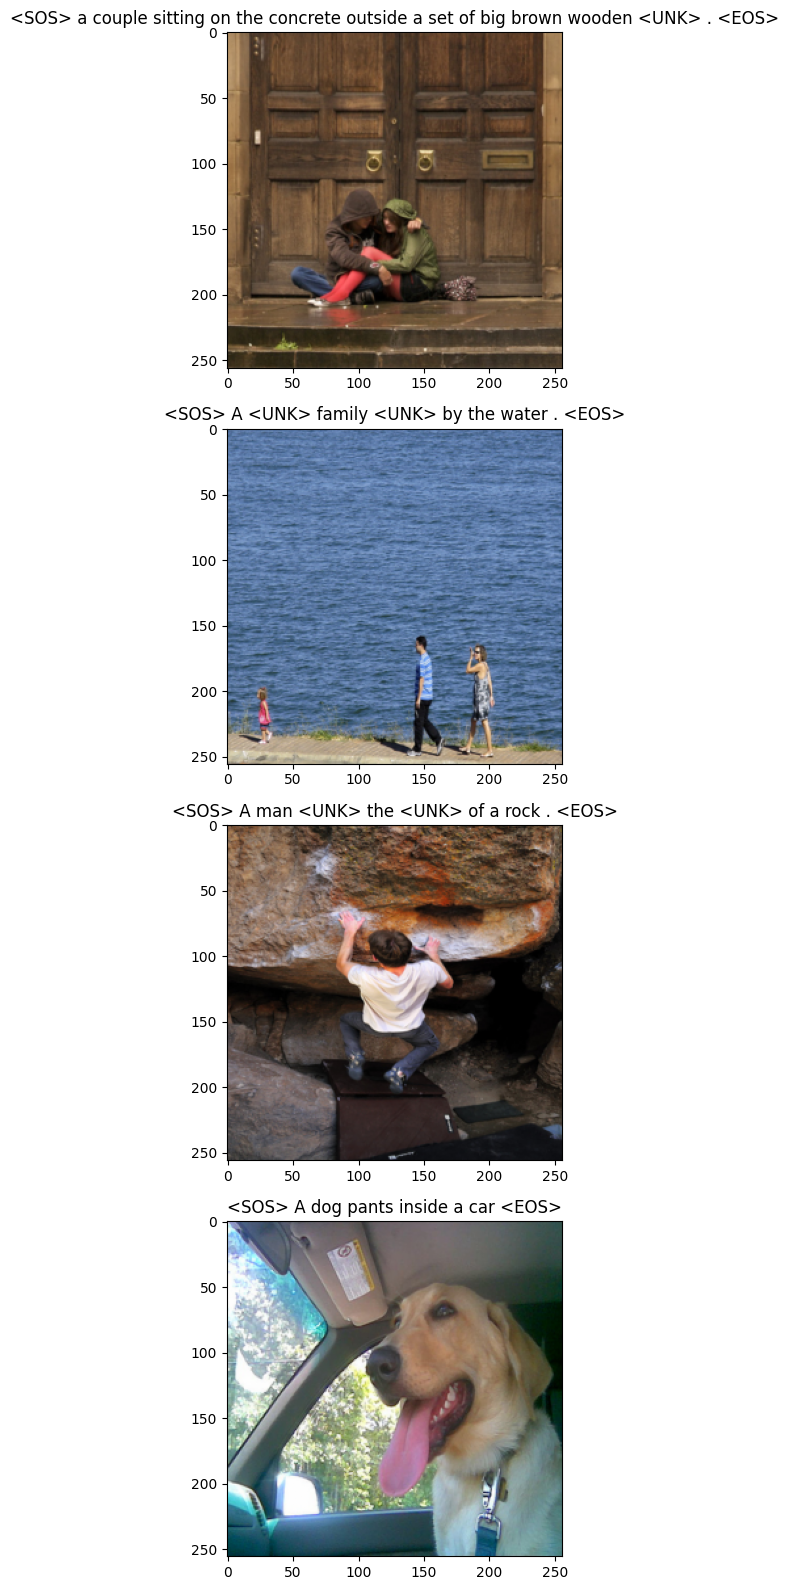

In [11]:
# ADD YOUR CODE HERE
# Example with batch=4
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

# 定义数据变换
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# 假设你已经定义并实例化了你的FlickrDataset
dataset = FlickrDataset(root_dir='/content/Images', captions_file='/content/captions.json', transform=transform)

# 定义一个函数来填充字幕
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    images, captions, lengths = zip(*batch)

    # Convert images to tensors
    images = torch.stack(images)

    # Flatten captions into a single list of tensors
    captions_flat = [cap for cap_list in captions for cap in cap_list]

    # Pad captions
    padded_captions = pad_sequence(captions_flat, batch_first=True, padding_value=0)

    return images, padded_captions, lengths


# 创建DataLoader
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# 在DataLoader上迭代
for images, padded_captions, lengths in dataloader:
    # 在训练/验证/测试代码中使用这些数据
    pass

import matplotlib.pyplot as plt
import numpy as np

def show_batch(images, captions, vocab):
    batch_size = len(images)
    fig, axes = plt.subplots(batch_size, 1, figsize=(16, 16))
    for i in range(batch_size):
        image = images[i].permute(1, 2, 0)
        axes[i].imshow(image)
        axes[i].axis('on')

        # Initialize caption
        caption = ''

        # Display captions
        for j, caption_token in enumerate(captions[i]):
            caption_word = vocab.idx2word[caption_token.item()]
            if caption_word == '<EOS>':
                caption += ' ' + caption_word
                break
            if j == 0:
                caption = caption_word
            else:
                caption += ' ' + caption_word
        axes[i].set_title(caption)
    plt.tight_layout()
    plt.show()

# 假设已经定义了和实例化了你的FlickrDataset和DataLoader
batch_images, batch_captions, _ = next(iter(dataloader))
show_batch(batch_images, batch_captions, dataset.vocab)


#2. MODEL
For this assignment, you are required to create your own custom image captioning model and compare its performance with an existing pre-trained model.

In [12]:
#Make sure to use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 2.1. Custom Image Captioning model

Create an Encoder-Attention-Decoder architecture with the following details:
- the encoder should process the images, thus you can create a Convolutional based architecture or use already pre-trained models like ResNet. However, you must fine-tune the pretrained model. The encoder is responisble for extracting image features;
- the attention layer should be between the encoder and decoder. It uses the image features from the encoder in order to provide context (attention scores) to the decoder hidden layers. For simplicity use Linear layers as the attention architecture;
- the decoder should be a sequence based model (i.e. LSTM) in order to process and generate captions.

Extra:
- Extra points (counting toward the final grade) will be given to any student who implements either a Vision-based Transformer architecture or a Transformer only decoder for the decoder part.

#### Reference
Here is an example of something similar to what we want to create:
<img src="https://drive.google.com/thumbnail?id=1wdddaLit7iEyCcVy5bS505NiYzL6c-4x&sz=w1000">


In [13]:
import torch.nn as nn
import torchvision.models as models

class FineTunedEncoder(nn.Module):
    def __init__(self, embed_size, fine_tune=True):
        super(FineTunedEncoder, self).__init__()
        resnet = models.resnet50(pretrained=True)  # 加载预训练的ResNet-50
        modules = list(resnet.children())[:-2]    # 移除最后两层（avgpool和fc）
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((14, 14))
        # 计算应输入到全连接层的特征总数
        self.flattened_size = 14 * 14 * 2048
        self.fc = nn.Linear(self.flattened_size, embed_size)  # 修改全连接层的输入维度为 embed_size
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # 是否对ResNet进行fine-tuning
        self.fine_tune = fine_tune
        if not fine_tune:
            for param in self.resnet.parameters():
                param.requires_grad = False

    def forward(self, images):
        features = self.resnet(images)
        features = self.adaptive_pool(features)
        features = features.permute(0, 2, 3, 1)
        features = features.reshape(features.size(0), -1)
        features = self.dropout(self.relu(self.fc(features)))
        return features


# 使用示例
embed_size = 512
encoder = FineTunedEncoder(embed_size, fine_tune=True)

# 封装成一个模块
class ImageEncoder(nn.Module):
    def __init__(self, embed_size, fine_tune=True):
        super(ImageEncoder, self).__init__()
        self.encoder = FineTunedEncoder(embed_size, fine_tune=fine_tune)

    def forward(self, images):
        return self.encoder(images)

# 使用示例
encoder = ImageEncoder(embed_size, fine_tune=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


In [14]:
# ADD YOUR CODE HERE
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # 编码器特征的线性层
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # 解码器隐藏状态的线性层
        self.full_att = nn.Linear(attention_dim, 1)  # 全连接层，用于计算注意力权重
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)  # 编码器特征
        att2 = self.decoder_att(decoder_hidden)  # 解码器隐藏状态
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1)))  # 计算注意力权重
        alpha = self.softmax(att.squeeze(2))  # 注意力权重
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # 上下文向量
        return context, alpha

# 定义参数
encoder_dim = 512
decoder_dim = 512
attention_dim = 512

# 创建 Attention 实例
attention = Attention(encoder_dim, decoder_dim, attention_dim)

In [15]:
# ADD YOUR CODE HERE
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerDecoder, TransformerDecoderLayer

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, decoder_dim, num_layers, attention_dim, dropout=0.5):
        super(TransformerDecoder, self).__init__()
        self.embed_size = embed_size
        self.decoder_dim = decoder_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.pos_encoder = PositionalEncoding(embed_size, dropout)

        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(embed_size, attention_dim, decoder_dim, dropout),
            num_layers=num_layers)

        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, memory, src_mask, trg_mask):
        trg_seq_len, batch_size = trg.size()

        # Embedding and positional encoding
        trg = self.embedding(trg) * math.sqrt(self.embed_size)
        trg = self.pos_encoder(trg)

        trg = trg.squeeze()

        print("After embedding and positional encoding trg:", trg.shape)
        print("After embedding and positional encoding memory:", memory.shape)
        print("After embedding and positional encoding tgt_mask:", trg_mask.shape)

        output = self.transformer_decoder(trg, memory, tgt_mask=trg_mask)  # 修改这里的参数

        print("After transformer decoder:", output.shape)

        output = self.fc_out(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Define parameters for the Transformer decoder
vocab_instance = Vocabulary()
vocab_size = len(vocab_instance)
decoder_embed_size = 512
decoder_dim = 512  # 假设这是解码器的维度
num_layers = 3
attention_dim = 512
dropout = 0.5

# Instantiate the Transformer decoder
decoder = TransformerDecoder(vocab_size, decoder_embed_size, decoder_dim, num_layers, attention_dim, dropout)


Combine the encoder - attention - decoder

In [16]:
# ADD YOUR CODE HERE
import torch.nn as nn

class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, attention, decoder):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = encoder
        self.attention = attention
        self.decoder = decoder

    def forward(self, images, captions, lengths, src_mask, trg_mask):
        features = self.encoder(images)
        # 假设 attention 层可以直接处理 features 而不需要初始化的隐藏状态
        context, score = self.attention(features, features)
        print("context output shape:", context.shape)
        print("score output shape:", score.shape)
        outputs = self.decoder(captions, context, src_mask, trg_mask)
        print("Final output shape:", outputs.shape)
        return outputs

# 创建 ImageCaptioningModel 的实例
model = ImageCaptioningModel(encoder, attention, decoder)

# 打印模型结构
print(model)

ImageCaptioningModel(
  (encoder): ImageEncoder(
    (encoder): FineTunedEncoder(
      (resnet): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tru

### 2.2. Training custom model

### Important: we recommend saving the model during training, so that you can resume training later in case of any Google Colab issue or limitation

In [17]:
# ADD YOUR CODE HERE
#save a model (call this in the training loop)
import torch

def save_model(model, num_epochs, file_path):
    model_state = {
        'embed_size': model.embed_size,
        'attention_dim': model.attention_dim,
        'encoder_dim': model.encoder_dim,
        'decoder_dim': model.decoder_dim,
        'state_dict': model.state_dict(),
        'num_epochs': num_epochs
    }

    torch.save(model_state, file_path)
    print('Model saved to model.pth')

def load_model(model, file_path):
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['state_dict'])
    return model, checkpoint['num_epochs']


Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.

In [18]:
# ADD YOUR CODE HERE
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

def train_model(model, criterion, optimizer, train_loader, val_loader, trg_mask, num_epochs, device):
    train_losses = []
    val_losses = []

    # Make sure the model is on the right device
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()  # 开始训练模式
        running_train_loss = 0.0
        src_mask = torch.zeros(32, 10).type(torch.bool)

        for images, captions, lengths in train_loader:
            images = images.to(device)
            optimizer.zero_grad()

            # Print captions to inspect the format
            print("Captions type:", type(captions))
            print("Captions:", captions)

            for j in range(len(captions)):
                captions_j = torch.stack([cap.to(device) for cap in captions[j]], dim=0)
                lengths_j = lengths[j].clone().detach().to(device)

                # Assuming your model is called model, modify the forward call accordingly
                outputs = model(images, captions_j, lengths_j, src_mask, trg_mask)  # 传递 src_mask

                loss = criterion(outputs, captions_j, lengths_j)
                loss.backward()
                running_train_loss += loss.item() * images.size(0)

            optimizer.step()

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, captions, lengths in val_loader:
                images = images.to(device)
                for i in range(len(captions)):
                    captions_i = [cap.to(device) for cap in captions[i]]
                    lengths_i = lengths[i].clone().detach().to(device)

                    # Modify the model forward propagation call to pass the src_mask
                    outputs = model(images, captions_i, lengths_i, src_mask, trg_mask)

                    loss = criterion(outputs, captions_i, lengths_i)
                    running_val_loss += loss.item() * images.size(0)

        # Calculate the average verification loss per cycle
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    return train_losses, val_losses




def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Set up your model, criterion, optimizer, train_loader, val_loader, and device

# 定义损失函数（criterion）
criterion = nn.CrossEntropyLoss()

# 定义优化器（optimizer）
learning_rate=0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 定义数据加载器
batch_size = 50
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

trg_seq_len = 50
trg_mask = torch.triu(torch.full((trg_seq_len, trg_seq_len), float('-inf')), diagonal=1).to(device)


train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, trg_mask, device=device, num_epochs=10)
plot_losses(train_losses, val_losses)


Captions type: <class 'torch.Tensor'>
Captions: tensor([[[  1,   4,  62,  ...,   0,   0,   0]],

        [[  1,   4, 102,  ...,   0,   0,   0]],

        [[  1,   4,   5,  ...,   0,   0,   0]],

        ...,

        [[  1,   4,  19,  ...,   0,   0,   0]],

        [[  1,   3, 605,  ...,   0,   0,   0]],

        [[  1,   4,   5,  ...,   0,   0,   0]]])
context output shape: torch.Size([50, 512])
score output shape: torch.Size([50, 50])
After embedding and positional encoding trg: torch.Size([50, 512])
After embedding and positional encoding memory: torch.Size([50, 512])
After embedding and positional encoding tgt_mask: torch.Size([50, 50])


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


**Visualize the attention weigths in order to understand how your model learned (Failure to do this, will result in losing points).
For that, use the 'context' variable returned by the Attention class to overlay them on the image.**  

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


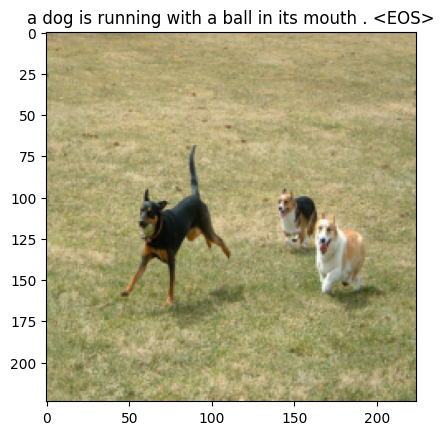

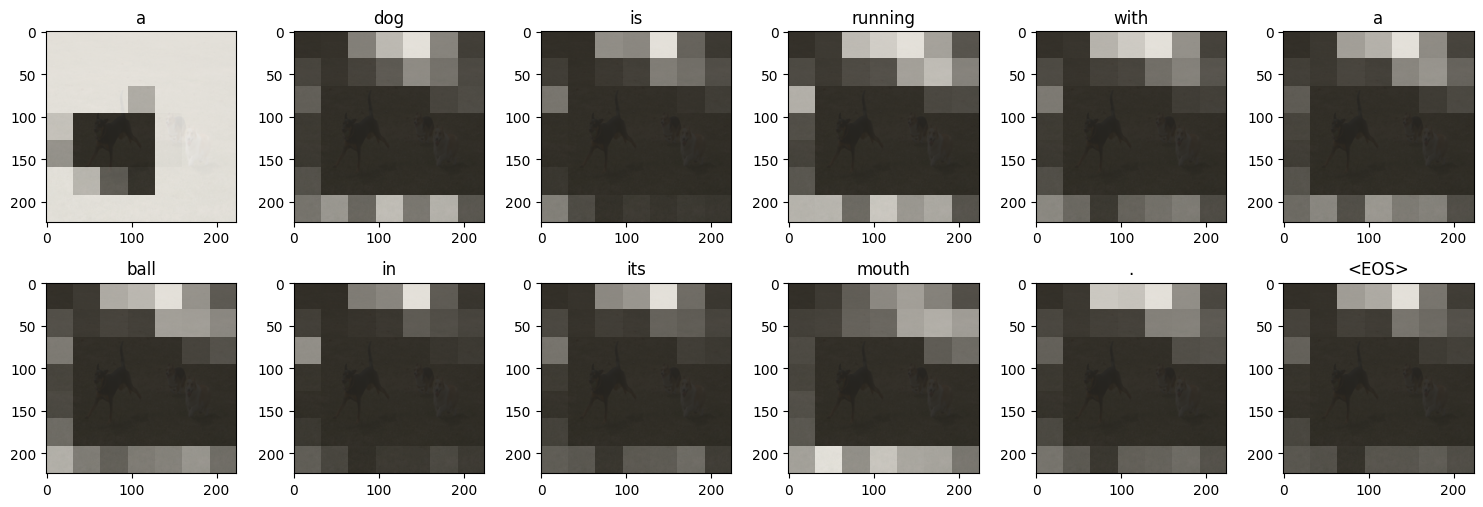

In [ ]:
# ADD YOUR CODE HERE

### 2.3. Evaluation on test set

Evaluate your trained model on the test set. Use the BLEU score as your metric: torchtext.data.metrics.bleu_score(...)

You may try BLEU-1,2 and 3.

In [ ]:
# ADD YOUR CODE HERE

### 2.4. Load an existing Image Captioning model
Feel free to choose any pre-trained image captioning model. For simplicity, try choosing a model already trained on Flickr8k.

In [ ]:
# ADD YOUR CODE HERE
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds


predict_step(['doctor.e16ba4e4.jpg']) # ['a woman in a hospital bed with a woman in a hospital bed']

### 2.5 Evaluate the chosen pre-trained captioning model on the test set
Use the same metrics chosen on step 2.3.

In [ ]:
# ADD YOUR CODE HERE

# 3. COMPARISON
Compare the performance of the two models. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?

In [ ]:
# ADD YOUR CODE HERE